In [17]:
# https://huggingface.co/indolem/indobertweet-base-uncased
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModel,BertTokenizer,AutoConfig
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline 
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch

In [19]:
df = pd.read_csv('/kaggle/input/random-tweet-dataset/dataset-clean.csv')
df

,text_akhir,polarity
0,coba spill jokes cowok lucu dengar,positive
1,fitur diilangin anjimmmmmm,positive
2,spill isi direct message artis favorit cringe ...,negative
3,beliau paham paham,positive
4,cekikik wkkwkwk coba gess tunjukun chat adik,positive
...,...,...
1602,lucu,positive
1603,NaN,positive
1604,moga kekal abadi maut pisah,positive
1605,NaN,positive


In [20]:
display(df.isna().sum())
df['text_akhir'].fillna('', inplace=True)
display(df.isna().sum())

text_akhir    19
polarity       0
dtype: int64

/tmp/ipykernel_31/1680636529.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['text_akhir'].fillna('', inplace=True)


text_akhir    0
polarity      0
dtype: int64

In [21]:
df=df.rename(columns={"text_akhir": "text"})

In [22]:
texts = df['text'].tolist()
texts

['coba spill jokes cowok lucu dengar',
 'fitur diilangin anjimmmmmm',
 'spill isi direct message artis favorit cringe dipikirpikir ill go first',
 'beliau paham paham',
 'cekikik wkkwkwk coba gess tunjukun chat adik',
 'tolong kecil gb instagram',
 'selamat malam firda ruwet',
 'brainrot indonesia brainrot italia',
 'ih senang calon suami tuju veksetomi',
 'kesal selang menit tidur masul akal call duakali banget',
 'kesal cerita direpost ditag lagu asa kesana izinin pakai',
 'drop meme tertawa hwhhehhehehe',
 'rebu gas roti es krim jual',
 'pikir pas coba garis',
 'cowok suka teknik',
 'turut wajar anak kelas bikin makalah kaget kesal lihat',
 'hati hati pasang suami istri hubung mending normal normal takut talak xixi',
 'kurir bi laik',
 'spill chat lucu toksik egkpp',
 'watashi proses diet but my ibuk everyday masak if watashi mangan masakan my ibuk become sad solusi yorobun suwun',
 'roblox main roblox suka main map saran seru',
 'eh numbuh daon bawang iseng naro toples seru anjir',

In [23]:
#konfigurasi penamaan label sesuai dengan kelas sentimen yang digunakan
id2label = {
    0: "negative",
    1: "positive"
  }
label2id= {
    "negative": 0,
    "positive": 1
  }


In [24]:
config = AutoConfig.from_pretrained("indolem/indobertweet-base-uncased")

config.label2id = label2id
config.id2label = id2label
config._num_labels = len(label2id)

In [25]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased",config=config)
model.config

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_attn_implementation_autoset": true,
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31923
}

In [26]:
# labelling sentimen

# Prediksi label
prediksi_label = []
for text in texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    prediksi_label.append(id2label[pred])

df["prediksi_label"] = prediksi_label
print(df.head())

                                                text  polarity prediksi_label
0                 coba spill jokes cowok lucu dengar  positive       positive
1                         fitur diilangin anjimmmmmm  positive       positive
2  spill isi direct message artis favorit cringe ...  negative       positive
3                                 beliau paham paham  positive       positive
4       cekikik wkkwkwk coba gess tunjukun chat adik  positive       positive


In [27]:
df["prediksi_label"].value_counts()

prediksi_label
positive    1508
negative      99
Name: count, dtype: int64

In [28]:
data_baru = df[["text","prediksi_label"]]
data_baru.rename(columns={"prediksi_label": "label"}, inplace=True)

/tmp/ipykernel_31/751845085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_baru.rename(columns={"prediksi_label": "label"}, inplace=True)


In [29]:
data_baru["label"].drop_duplicates()

0    positive
6    negative
Name: label, dtype: object

In [30]:
le = LabelEncoder()
data_baru["label"] = le.fit_transform(data_baru["label"])
display(data_baru["label"].value_counts())
display(data_baru)

/tmp/ipykernel_31/1502206328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_baru["label"] = le.fit_transform(data_baru["label"])


label
1    1508
0      99
Name: count, dtype: int64

,text,label
0,coba spill jokes cowok lucu dengar,1
1,fitur diilangin anjimmmmmm,1
2,spill isi direct message artis favorit cringe ...,1
3,beliau paham paham,1
4,cekikik wkkwkwk coba gess tunjukun chat adik,1
...,...,...
1602,lucu,1
1603,,1
1604,moga kekal abadi maut pisah,1
1605,,1


In [31]:
data_baru[['text','label']].to_csv('dataset-bert.csv', index=False)

In [32]:
train_valid_ratio = 0.80
train_test_ratio = 0.20

#train test split
df_train, df_test = train_test_split(data_baru, test_size = train_test_ratio, random_state = 42)
print("Train Shape",df_train.shape)
print("Test Shape",df_test.shape)

Train Shape (1285, 2)
Test Shape (322, 2)


In [33]:
#prepare data train and validation
import pandas as pd
df_val = pd.DataFrame()

print(df_train.shape)
for row in data_baru['label'].drop_duplicates():
  df_val = pd.concat([df_val, df_train.loc[df_train['label']==row]], ignore_index=True)

df_train = df_val
print(df_train.shape)

(1285, 2)
(1285, 2)


In [34]:
df_train

,text,label
0,bocah cilik iya,1
1,jne jne,1
2,tolong jadi salah komando distrik militer kals...,1
3,persis beda tangga kabur pas libur natal kemar...,1
4,baca bahak,1
...,...,...
1280,tetangga threads tolong jambakin rambut botak,0
1281,manusia sticker,0
1282,eh numbuh daon bawang iseng naro toples seru a...,0
1283,mfs foto abu ayo cerita gess,0


In [35]:
dataset_train = Dataset.from_dict(df_val)
dataset_val =  Dataset.from_dict(df_test)
print("Dataset Train : ",dataset_train)
print("Dataset Val : ",dataset_val)

Dataset Train :  Dataset({
    features: ['text', 'label'],
    num_rows: 1285
})
Dataset Val :  Dataset({
    features: ['text', 'label'],
    num_rows: 322
})


In [36]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

In [37]:
dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_val = dataset_val.map(tokenize_function, batched=True)

Map:   0%|          | 0/1285 [00:00<?, ? examples/s]

Map:   0%|          | 0/322 [00:00<?, ? examples/s]

In [38]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [39]:
training_args = TrainingArguments("test_trainer", eval_strategy="epoch",per_device_train_batch_size=8,num_train_epochs=8,learning_rate=2e-5,logging_steps=1, report_to="none")
trainer = Trainer(model=model.cuda(), args=training_args, train_dataset=dataset_train, eval_dataset=dataset_val,compute_metrics=compute_metrics)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.066200,0.175674,0.940994,0.484800,0.470497,0.500000
2,1.125600,0.155387,0.944099,0.576440,0.806688,0.550981
3,0.003800,0.210125,0.944099,0.610484,0.774763,0.575647
4,0.049700,0.221416,0.950311,0.701299,0.812567,0.652944
5,0.001500,0.249998,0.950311,0.701299,0.812567,0.652944
6,0.001000,0.275265,0.944099,0.685342,0.751827,0.649644
7,0.000400,0.292565,0.950311,0.701299,0.812567,0.652944
8,0.000400,0.301018,0.947205,0.693075,0.779167,0.651294


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/li

TrainOutput(global_step=648, training_loss=0.08097290895409655, metrics={'train_runtime': 597.7399, 'train_samples_per_second': 17.198, 'train_steps_per_second': 1.084, 'total_flos': 2704781649100800.0, 'train_loss': 0.08097290895409655, 'epoch': 8.0})

In [40]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [41]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.3010179102420807,
 'eval_accuracy': 0.9472049689440993,
 'eval_f1': 0.6930754135127558,
 'eval_precision': 0.7791666666666667,
 'eval_recall': 0.6512940767760986,
 'eval_runtime': 5.7752,
 'eval_samples_per_second': 55.756,
 'eval_steps_per_second': 3.636,
 'epoch': 8.0}

In [42]:
#convert dataframe to dataset type
dataset_test= Dataset.from_dict(df_test)
dataset_test = dataset_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/322 [00:00<?, ? examples/s]

In [43]:
#convert predicted_review = trainer.predict(dataset_test)
predicted_review = trainer.predict(dataset_test)
raw_pred, _, _ = predicted_review
predclas= np.argmax(raw_pred, axis=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [44]:
df_test["label"]

530     1
1331    0
168     1
135     0
438     1
       ..
1181    1
1322    1
1551    1
494     1
705     1
Name: label, Length: 322, dtype: int64

In [45]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

Confusion Matrix
[[  6  13]
 [  4 299]]


Accuracy: 94.72049689440993
Precision: 77.91666666666667
Recall: 65.12940767760986
F1-Score: 69.30754135127557


              precision    recall  f1-score   support

           0     0.6000    0.3158    0.4138        19
           1     0.9583    0.9868    0.9724       303

    accuracy                         0.9472       322
   macro avg     0.7792    0.6513    0.6931       322
weighted avg     0.9372    0.9472    0.9394       322



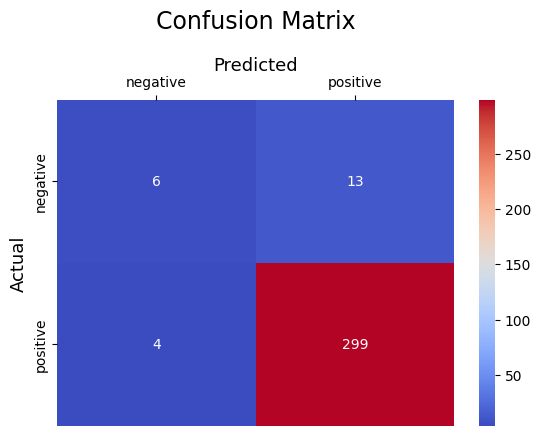

In [46]:
def findMetrics(test, pred):
    labels_test = np.sort(test.unique())
    cm = confusion_matrix(test, pred, labels=labels_test)
    print("Confusion Matrix")
    print(cm)

    print("\n")
    print("Accuracy:", accuracy_score(test, pred) * 100)
    print("Precision:", precision_score(test, pred, average='macro') * 100)
    print("Recall:", recall_score(test, pred, average='macro') * 100)
    print("F1-Score:", f1_score(test, pred, average='macro') * 100)
    print("\n")
    print(classification_report(test, pred, labels=labels_test, digits=4))

    emotion_labels = le.inverse_transform(labels_test)
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Confusion Matrix', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top')
    plt.ylabel('Actual', fontsize=13)
    plt.xlabel('Predicted', fontsize=13)
    plt.gca().xaxis.tick_top()

    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.show()

findMetrics(df_test['label'], predclas)